In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load metadata
metadata = pd.read_excel("D:\\My_Acad\\VS_Code\\Sem_6_code\\DL\\project\\kishore_code\\VQA_RAD Dataset Public.xlsx")

In [3]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2248 entries, 0 to 2247
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   QID_unique    2248 non-null   int64 
 1   QID_para      2248 non-null   object
 2   QID_linked    2248 non-null   object
 3   IMAGEID_case  2248 non-null   object
 4   IMAGEID       2248 non-null   object
 5   IMAGEORGAN    2248 non-null   object
 6   EVALUATION    2248 non-null   object
 7   QUESTION      2248 non-null   object
 8   Q_REPHASE     1776 non-null   object
 9   Q_RELATION    1487 non-null   object
 10  Q_FRAMED      1267 non-null   object
 11  Q_TYPE        2248 non-null   object
 12  ANSWER        2247 non-null   object
 13  A_TYPE        2248 non-null   object
dtypes: int64(1), object(13)
memory usage: 246.0+ KB


In [4]:
metadata["Q_TYPE"].value_counts()

Q_TYPE
PRES            800
POS             316
ABN             202
OTHER           194
MODALITY        185
SIZE            171
PLANE           120
ATTRIB           87
ORGAN            59
COLOR            52
COUNT            24
POS, PRES         6
PRES, ATTRIB      6
PRES, POS         4
ATTRIB, PRES      4
ABN, POS          3
SIZE, PRES        2
Other             2
COLOR, PRES       2
POS, ABN          2
SIZE, COLOR       2
ATTRIB, SIZE      1
PRES, ABN         1
PRES, COLOR       1
ATRIB             1
PRSE              1
Name: count, dtype: int64

In [5]:
metadata.isna().sum()

QID_unique        0
QID_para          0
QID_linked        0
IMAGEID_case      0
IMAGEID           0
IMAGEORGAN        0
EVALUATION        0
QUESTION          0
Q_REPHASE       472
Q_RELATION      761
Q_FRAMED        981
Q_TYPE            0
ANSWER            1
A_TYPE            0
dtype: int64

In [6]:
metadata["A_TYPE"].value_counts()

A_TYPE
CLOSED     1297
OPEN        949
CLOSED        2
Name: count, dtype: int64

In [7]:
metadata["ANSWER"].value_counts()[:20]

ANSWER
No                                      486
Yes                                     347
yes                                     239
no                                      120
Axial                                    28
Right                                    22
Left                                     18
PA                                       15
axial                                    15
CT                                       13
Brain                                    10
MRI                                       8
Right side                                8
fat                                       7
Right upper lobe                          7
Right lung                                7
5.6cm focal, predominantly hypodense      6
Bilateral                                 6
Diffuse                                   6
Left kidney                               6
Name: count, dtype: int64

<Axes: xlabel='IMAGEORGAN'>

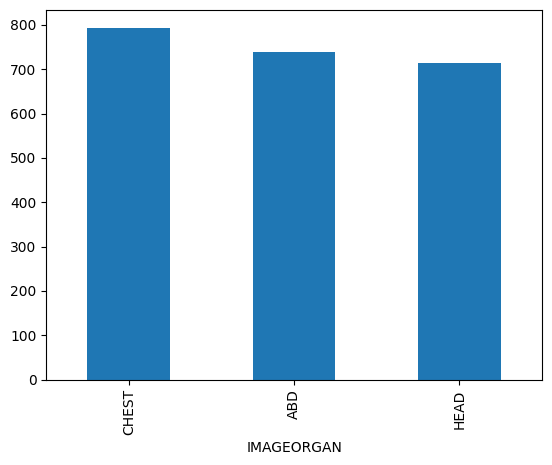

In [8]:
metadata["IMAGEORGAN"].value_counts().plot.bar()

In [9]:
# Filter metadata to include only entries with A_TYPE as "CLOSED"
metadata = metadata[metadata["A_TYPE"] == "CLOSED"]

In [10]:
# Further filter metadata to include only entries with "yes" and "no" answers
sampledata = metadata[(metadata["ANSWER"].str.lower() == "yes") | (metadata["ANSWER"].str.lower() == "no")]
sampledata.reset_index(inplace=True, drop=True)

In [11]:
# Convert answers to binary labels
labels = sampledata["ANSWER"].str.lower().map({'yes': 1, 'no': 0}).values
print(labels)

[1 0 0 ... 1 1 1]


In [12]:
# Tokenize questions
docx = sampledata["QUESTION"].tolist()
tokenizer = Tokenizer(oov_token="<nothing>")
tokenizer.fit_on_texts(docx)
sequences = tokenizer.texts_to_sequences(docx)
sequences = pad_sequences(sequences, padding="post", maxlen=10)

In [13]:
print(sequences)

[[  9 478   8 ...   0   0   0]
 [  9   3  49 ...   0   0   0]
 [  2   4  15 ...   0   0   0]
 ...
 [  2   4 458 ...   0   0   0]
 [  2   5   7 ...   0   0   0]
 [  2   5  82 ... 204   0   0]]


In [14]:
# Prepare image addresses
IMGDIR = "D:\\My_Acad\\VS_Code\\Sem_6_code\\DL\\project\\kishore_code\\VQA_RAD Image Folder\\"
addresses = [IMGDIR + img_id.split('/')[-1] for img_id in sampledata["IMAGEID"]]

In [15]:
# Split data into training and validation sets
train_addresses, val_addresses, ytrain, ytest = train_test_split(addresses, labels, test_size=0.2, random_state=42)
train_sequences, val_sequences, ytrain, ytest = train_test_split(sequences, labels, test_size=0.2, random_state=42)

## **Custom CNN with Bi LSTM with Multi Head Attention Mechanism**

In [16]:
from PIL import Image

# Data augmentation and processing functions
def augment_data(image):
    # Convert numpy array to PIL image
    image = Image.fromarray(image)
    transform = transforms.Compose([
        transforms.RandomRotation(20),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor()
    ])
    return transform(image)

def process_data(image_path, text_sequence, label):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = augment_data(image)
    text_sequence = torch.tensor(text_sequence, dtype=torch.long)
    label = torch.tensor(label, dtype=torch.float32)
    return image, text_sequence, label

In [17]:
class VQADataset(Dataset):
    def __init__(self, addresses, sequences, labels):
        self.addresses = addresses
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.addresses)

    def __getitem__(self, idx):
        image, text_sequence, label = process_data(self.addresses[idx], self.sequences[idx], self.labels[idx])
        return image, text_sequence, label

In [18]:
BATCH_SIZE = 32
BUFFER_SIZE = 500

train_dataset = VQADataset(train_addresses, train_sequences, ytrain)
val_dataset = VQADataset(val_addresses, val_sequences, ytest)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [19]:
# Define the Multi-Head Self-Attention layer
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        if embed_dim % self.num_heads != 0:
            raise ValueError(f"embed_dim must be divisible by num_heads. Got embed_dim={embed_dim} and num_heads={num_heads}.")
        self.projection_dim = embed_dim // num_heads
        self.query_dense = nn.Linear(embed_dim, embed_dim)
        self.key_dense = nn.Linear(embed_dim, embed_dim)
        self.value_dense = nn.Linear(embed_dim, embed_dim)
        self.combine_heads = nn.Linear(embed_dim, embed_dim)

    def attention(self, query, key, value):
        score = torch.matmul(query, key.transpose(-2, -1))
        dim_key = torch.tensor(key.shape[-1], dtype=torch.float32)
        scaled_score = score / torch.sqrt(dim_key)
        weights = nn.functional.softmax(scaled_score, dim=-1)
        output = torch.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = x.reshape(batch_size, -1, self.num_heads, self.projection_dim)
        return x.permute(0, 2, 1, 3)

    def forward(self, inputs):
        batch_size = inputs.shape[0]
        seq_len = inputs.shape[1]
        forward_hidden, backward_hidden = inputs.chunk(2, dim=2)
        combined_hidden = torch.cat([forward_hidden, backward_hidden], dim=2)
        query = self.query_dense(combined_hidden)
        key = self.key_dense(combined_hidden)
        value = self.value_dense(combined_hidden)
        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)
        attention, weights = self.attention(query, key, value)
        attention = attention.permute(0, 2, 1, 3).contiguous()
        concat_attention = attention.reshape(batch_size, seq_len, self.embed_dim)
        output = self.combine_heads(concat_attention)
        return output

In [20]:
# Define the model class
class CustomCNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim=64, hidden_size=64, num_layers=2, bidirectional=True):
        super(CustomCNNModel, self).__init__()
        # Image branch
        self.image_branch = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4),
            nn.Conv2d(64, 128, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3),
            nn.Conv2d(128, 256, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3),
            nn.Flatten()
        )

        # Text branch
        self.text_branch = nn.Sequential(
            nn.Embedding(vocab_size, embedding_dim),
            nn.Dropout(0.4)
        )
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)

        # Attention layer
        self.attention_layer = MultiHeadSelfAttention(embed_dim=hidden_size * 2 if bidirectional else hidden_size, num_heads=8)

        # Combined branch
        self.combined_branch = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(200704 + (hidden_size * 2 if bidirectional else hidden_size), 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, images, texts):
        img_features = self.image_branch(images)
        text_features = self.text_branch(texts)
        text_features, _ = self.lstm(text_features)
        text_features = self.attention_layer(text_features)
        text_features = text_features[:, -1, :]  # Get the last hidden state
        combined_features = torch.cat((img_features, text_features), dim=1)
        output = self.combined_branch(combined_features)
        return output

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [22]:
# Define vocabulary size
vocab_size = sequences.max() + 1 
print(vocab_size)

820


In [23]:
# Define the model
model = CustomCNNModel(vocab_size).to(device)

In [24]:
# Print model summary
print(model)

CustomCNNModel(
  (image_branch): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.4, inplace=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.3, inplace=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.3, inplace=False)
    (12): Flatten(start_dim=1, end_dim=-1)
  )
  (text_branch): Sequential(
    (0): Embedding(820, 64)
    (1): Dropout(p=0.4, inplace=False)
  )
  (lstm): LSTM(64, 64, num_layers=2, batch_first=True, bidirectional=True)
  (attention_layer): MultiHeadSelfAttention(
    (query_dense): Linear(in_features=128, out_

In [25]:
# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

In [26]:
# Training loop
num_epochs = 25
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    
    for images, texts, labels in train_loader:
        images, texts, labels = images.to(device), texts.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images, texts)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        preds = torch.round(outputs)
        running_corrects += torch.sum(preds == labels.unsqueeze(1))
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    
    print(f"Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
    
    # Append accuracies to lists
    train_accuracies.append(epoch_acc.item())
    
    model.eval()
    val_corrects = 0
    with torch.no_grad():
        for images, texts, labels in val_loader:
            images, texts, labels = images.to(device), texts.to(device), labels.to(device)
            outputs = model(images, texts)
            preds = torch.round(outputs)
            val_corrects += torch.sum(preds == labels.unsqueeze(1))
    
    val_acc = val_corrects.double() / len(val_loader.dataset)
    val_accuracies.append(val_acc.item())

Epoch 0/24, Loss: 0.7110, Accuracy: 0.4764
Epoch 1/24, Loss: 0.6935, Accuracy: 0.4827
Epoch 2/24, Loss: 0.6929, Accuracy: 0.5163
Epoch 3/24, Loss: 0.6847, Accuracy: 0.5824
Epoch 4/24, Loss: 0.6626, Accuracy: 0.6254
Epoch 5/24, Loss: 0.6384, Accuracy: 0.6474
Epoch 6/24, Loss: 0.6224, Accuracy: 0.6506
Epoch 7/24, Loss: 0.6043, Accuracy: 0.6852
Epoch 8/24, Loss: 0.5716, Accuracy: 0.7104
Epoch 9/24, Loss: 0.5388, Accuracy: 0.7240
Epoch 10/24, Loss: 0.5292, Accuracy: 0.7324
Epoch 11/24, Loss: 0.5035, Accuracy: 0.7744
Epoch 12/24, Loss: 0.4778, Accuracy: 0.7733
Epoch 13/24, Loss: 0.4416, Accuracy: 0.7901
Epoch 14/24, Loss: 0.4410, Accuracy: 0.7796
Epoch 15/24, Loss: 0.4255, Accuracy: 0.7996
Epoch 16/24, Loss: 0.4034, Accuracy: 0.8006
Epoch 17/24, Loss: 0.3915, Accuracy: 0.8216
Epoch 18/24, Loss: 0.3888, Accuracy: 0.8248
Epoch 19/24, Loss: 0.3562, Accuracy: 0.8405
Epoch 20/24, Loss: 0.3454, Accuracy: 0.8520
Epoch 21/24, Loss: 0.3314, Accuracy: 0.8552
Epoch 22/24, Loss: 0.3338, Accuracy: 0.843

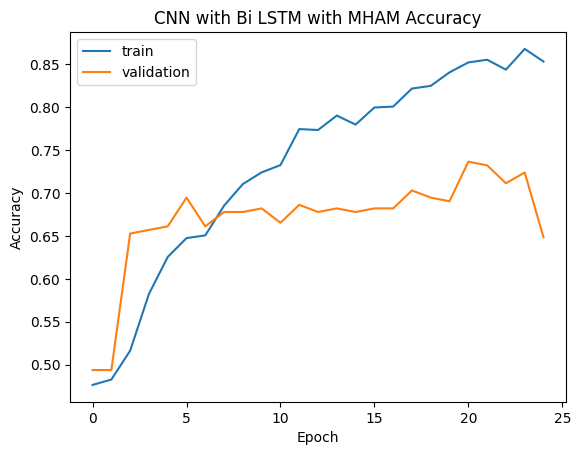

In [27]:
# Plot accuracy
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('CNN with Bi LSTM with MHAM Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [28]:
# Evaluate model on validation data
val_labels = []
val_predictions = []

with torch.no_grad():
    for images, texts, labels in val_loader:
        images, texts, labels = images.to(device), texts.to(device), labels.to(device)
        outputs = model(images, texts)
        preds = torch.round(outputs).cpu().numpy()
        val_predictions.extend(preds)
        val_labels.extend(labels.cpu().numpy())

val_predictions = np.array(val_predictions).flatten()
val_labels = np.array(val_labels).flatten()

accuracy = accuracy_score(val_labels, val_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(val_labels, val_predictions, average='binary')

print("CNN with Bi LSTM with MHAM Evaluation Metrics")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

CNN with Bi LSTM with MHAM Evaluation Metrics
Accuracy: 0.6485
Precision: 0.6214
Recall: 0.7373
F1-score: 0.6744


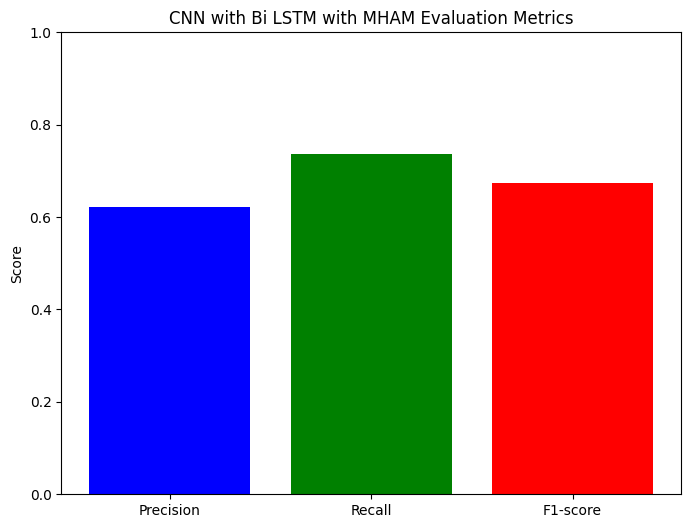

In [29]:
# Plot precision, recall, and F1-score
metrics = {'Precision': precision, 'Recall': recall, 'F1-score': f1}
plt.figure(figsize=(8, 6))
plt.bar(metrics.keys(), metrics.values(), color=['blue', 'green', 'red'])
plt.title('CNN with Bi LSTM with MHAM Evaluation Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()

In [30]:
# Save the trained model weights
torch.save(model.state_dict(), 'cnn_BiLSTM_MHAM_model.pth')